In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/medinazelimger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/medinazelimger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/medinazelimger/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Opinion Leaders 500e: Articles & Youtube Video Transcripts

In [25]:
opinionLeaders500_original = pd.read_csv('/Users/medinazelimger/Downloads/ARP/Web-Scraping Data and adjusting codes/Opinion Leaders/500e - Opinion Leaders.csv')
opinionLeaders500 = opinionLeaders500_original.copy()

Optimal settings: 5 topics, Alpha: 1, Passes: 10, Coherence Score: 0.32390679027325026


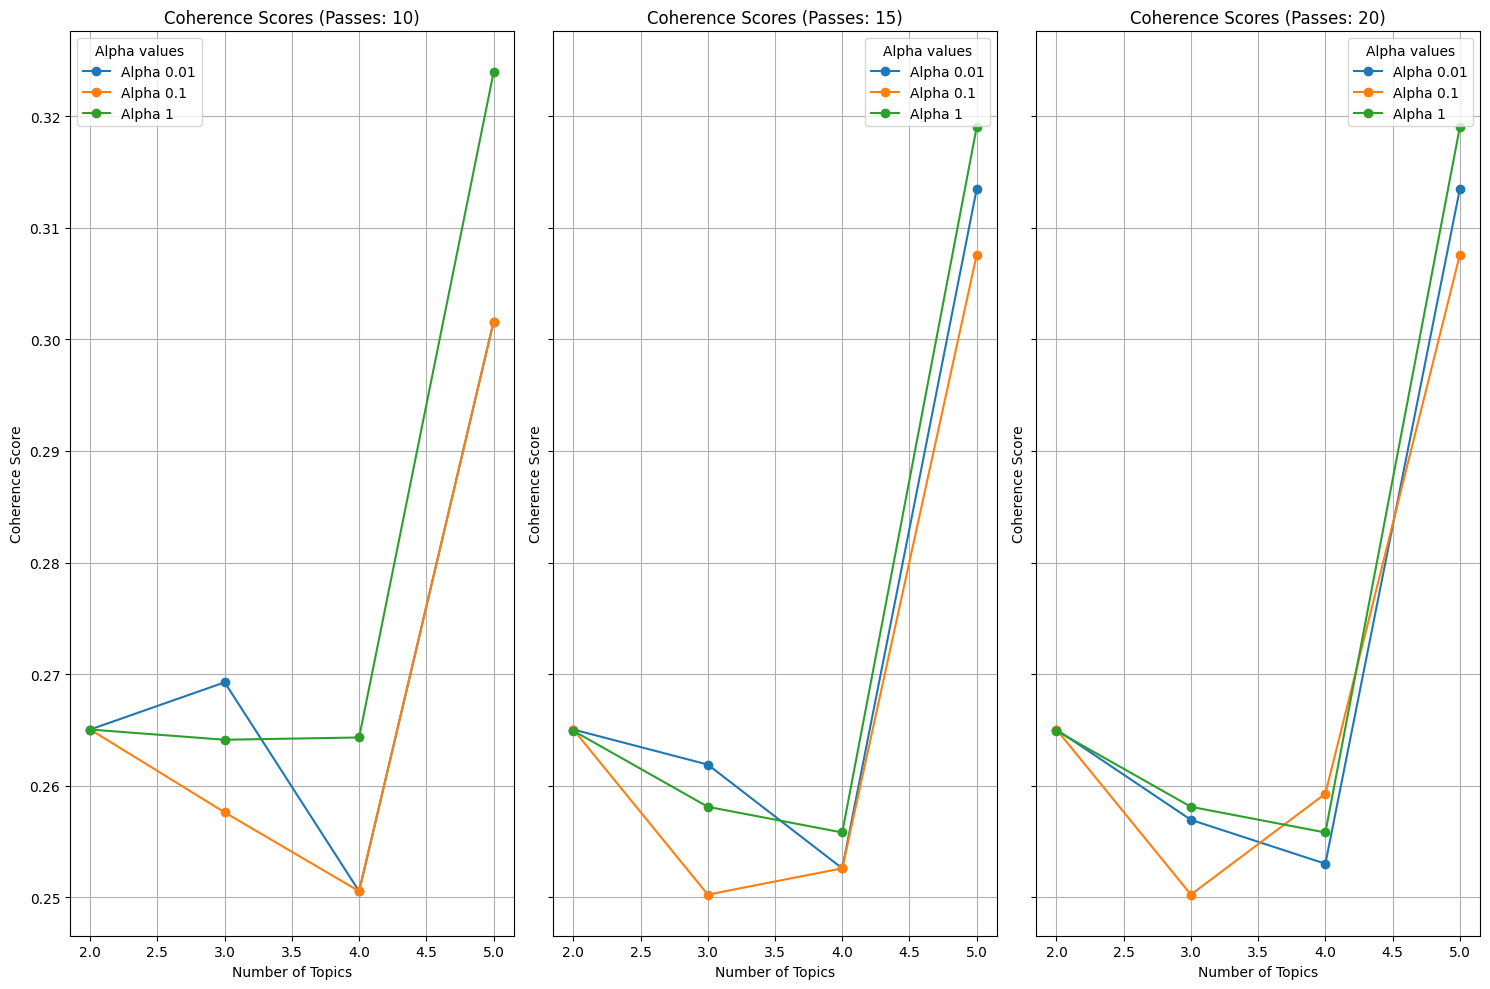

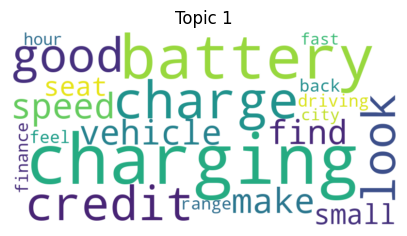

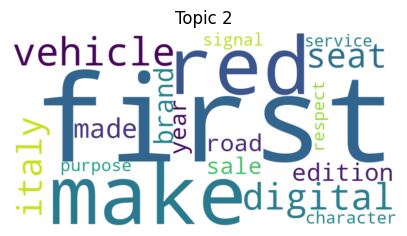

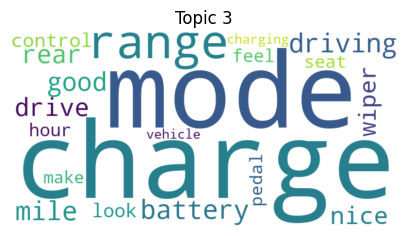

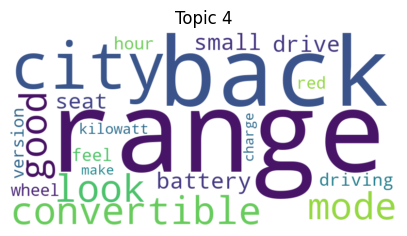

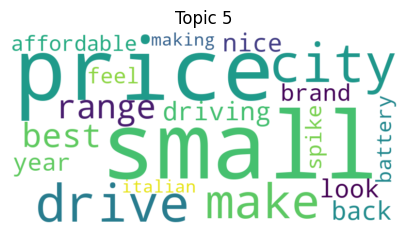

In [26]:
opinionLeaders500 = opinionLeaders500.drop(columns=['Date', 'Title', 'Channel Name'])

# Update stopwords handling
custom_stopwords = set(stopwords.words('english')).union({
     'electric','ev','model', 'car', 'cars', 'fiat', 'peugeot', 'jeep', 'hyundai', 'kona', 'mini','stellantis', 'sherpa','honda','zoe', 'renault', 'tesla','chinese','avenger', 'abarth',
    'market', 'available', 'new', 'offered', 'sold', 'week', 'level', 'move','presented',
    'would', 'also', 'like', 'even', 'according', 'one', 'since', 'still', 'two', 
    'content', 'information', 'interests', 'activity', 'mean', 'go', 'quit',
    'got', 'much', 'actual', 'thing', 'bit', 'see', 'think', 'yeah', 'know', 'and', 
    'way', 'come',  'example', 'esposito', 'lee', 'torque', 'ready', 'around', 'use', 'um', 
    'together', 'us', 'really', 'america', 'well', 'mirafiori', 'campaign', 'north',
    'bag', 'says', 'get', 'world', 'germani', 'belgium', 'spain',
    'uh', 'oh', 'im', 'thats', 'youre', 'weve', 'dont', 'actually', 'work', 'reuters','youve','there','going',
    'gelateria', 'list', 'required', 'instead', 'added', 'inbox',  'help', 'dedicated',
    'inform', 'news', 'group', 'report', 'couldnt', 'three', 'including', 'however', 'people',
    'ice', 'doesnt', 'less',  'kind', 'want', 'fat', 'okay', 'notice','be', 'comes', 'little', 'feeling', 
    'claim', 'ever', 'probably', 'take', 'something', 'end', 'many', 'ago', 'ive',
    'thought', 'claimed', 'data', 'review', 'isnt', 'regarding', 'listed', 'enable', 'saved', 'necessary',
    'said', 'may', 'point', 'armani', 'entity', 'giorgio', 'uk', 'lot', 'let', 'quite', 'need', 'e',
    'murray', 'gordon', 'could', 'turn', 'day', 'thinking', 'long', 'able', 
    'generation', 'consent', 'phev', 'bo', 'official', 'steve', 'delivers', 'f', 'browse', 'seventh', 'fourth','fowler',
    'auction', 'right', 'say', 'course', 'yes', 'spot', 'minute', 'time', 'form', 'choice', 'string', 'order'
})

def preprocess(text):
    # remove tabs and newlines
    text = re.sub(r'[\n\t]', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in custom_stopwords]
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Processing the documents
processed_docs = [preprocess(doc) for doc in opinionLeaders500['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Updated coherence function to iterate over multiple parameters
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range, passes_range):
    coherence_results = []
    model_list = []
    for num_passes in passes_range:
        for alpha in alpha_range:
            for num_topics in num_topics_range:
                model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, passes=num_passes, random_state=610)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_results.append({
                    "model": model,
                    "alpha": alpha,
                    "num_topics": num_topics,
                    "passes": num_passes,
                    "coherence": coherencemodel.get_coherence()
                })
    return model_list, coherence_results

# Compute models and coherence
num_topics_range = range(2, 6)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_OL500 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_OL500['num_topics']} topics, Alpha: {optimal_result_OL500['alpha']}, Passes: {optimal_result_OL500['passes']}, Coherence Score: {optimal_result_OL500['coherence']}")


# Plotting the coherence scores
def plot_coherence_scores(coherence_results):
    # Get unique values for passes, alphas, and number of topics
    passes_values = sorted(set(result['passes'] for result in coherence_results))
    alpha_values = sorted(set(result['alpha'] for result in coherence_results))
    num_topics_values = sorted(set(result['num_topics'] for result in coherence_results))
    
    # Determine the layout of subplots
    num_plots = len(passes_values)
    num_cols = 3  # Define the number of columns in the subplot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the required number of rows

    # Create subplots with horisontal layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharey=True)
    axes = axes.flatten()  # Flatten in case we have a single row

    for idx, num_passes in enumerate(passes_values):
        ax = axes[idx]
        filtered_results = [result for result in coherence_results if result['passes'] == num_passes]

        for alpha in alpha_values:
            x = [result['num_topics'] for result in filtered_results if result['alpha'] == alpha]
            y = [result['coherence'] for result in filtered_results if result['alpha'] == alpha]
            ax.plot(x, y, marker='o', label=f'Alpha {alpha}')

        ax.set_title(f"Coherence Scores (Passes: {num_passes})")
        ax.set_xlabel("Number of Topics")
        ax.set_ylabel("Coherence Score")
        ax.legend(title='Alpha values')
        ax.grid(True)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_OL500 = optimal_result_OL500['model']
optimal_num_topics_OL500 = optimal_result_OL500['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=610)
for i in range(optimal_num_topics_OL500):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_OL500.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [27]:
lda_OL500 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_OL500, alpha=optimal_result_OL500['alpha'], passes=optimal_result_OL500['passes'], random_state=610)

In [28]:
for idx, topic in lda_OL500.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"charging" + 0.007*"battery" + 0.006*"charge" + 0.005*"good" + 0.005*"credit" + 0.005*"look" + 0.005*"speed" + 0.005*"make" + 0.005*"vehicle" + 0.005*"find"
Topic: 1 
Words: 0.011*"entity" + 0.007*"first" + 0.007*"choice" + 0.007*"make" + 0.006*"red" + 0.005*"vehicle" + 0.005*"digital" + 0.004*"seat" + 0.004*"italy" + 0.004*"made"
Topic: 2 
Words: 0.007*"charge" + 0.007*"mode" + 0.007*"range" + 0.007*"driving" + 0.007*"battery" + 0.006*"mile" + 0.006*"good" + 0.006*"rear" + 0.006*"drive" + 0.005*"nice"
Topic: 3 
Words: 0.013*"range" + 0.009*"back" + 0.007*"city" + 0.006*"convertible" + 0.006*"look" + 0.006*"mode" + 0.006*"good" + 0.006*"battery" + 0.006*"small" + 0.006*"drive"
Topic: 4 
Words: 0.008*"small" + 0.007*"price" + 0.006*"city" + 0.005*"drive" + 0.005*"ev" + 0.005*"make" + 0.005*"range" + 0.004*"best" + 0.004*"driving" + 0.004*"back"


In [29]:
# Visualise topics using pyLDAvis
OL500_vis = gensimvis.prepare(lda_OL500, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(OL500_vis)

In [30]:
# Get the topic distribution for each document
OL500_topic_matrix = [lda_OL500[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
opinionLeaders500['Topic 1'] = [dict(doc).get(0, 0) for doc in OL500_topic_matrix]
opinionLeaders500['Topic 2'] = [dict(doc).get(1, 0) for doc in OL500_topic_matrix]
opinionLeaders500['Topic 3'] = [dict(doc).get(2, 0) for doc in OL500_topic_matrix]
opinionLeaders500['Topic 4'] = [dict(doc).get(3, 0) for doc in OL500_topic_matrix]
opinionLeaders500['Topic 5'] = [dict(doc).get(4, 0) for doc in OL500_topic_matrix]

# Add 'Date' columns from the original table
date_map = dict(zip(opinionLeaders500_original['ID'], opinionLeaders500_original['Date']))
opinionLeaders500['Date'] = opinionLeaders500['ID'].map(date_map)

# Display the table with the new topic columns
opinionLeaders500.head()

,ID,Text,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Date
0,https://news.google.com/articles/CBMiKGh0dHBzO...,Fiat made the 2013 500e specifically for the U...,0.018342,0.013030,0.657889,0.301646,0.000000,2023-11-07
1,https://news.google.com/articles/CBMiLWh0dHBzO...,Save Money. Use the U.S. News Best Price Progr...,0.000000,0.000000,0.000000,0.970965,0.000000,2024-07-11
2,https://news.google.com/articles/CBMiLmh0dHBzO...,2024 Fiat 500e (Photo provided by Fiat) La Dol...,0.960987,0.018936,0.000000,0.000000,0.000000,2024-07-24
3,https://news.google.com/articles/CBMiMmh0dHBzO...,The Fiat 500e not only offers the lowest MSRP ...,0.864551,0.073012,0.019528,0.022529,0.020381,2024-05-08
4,https://news.google.com/articles/CBMiNmh0dHBzO...,See also: FIAT 500e: Electric Icon Arrives in ...,0.583710,0.254951,0.048410,0.055042,0.057888,2024-02-15


In [31]:
# Define a function to get the sentiment of a text
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to each document
opinionLeaders500['Sentiment'] = opinionLeaders500['Text'].apply(get_sentiment)

# Determine the primary topic for each document
opinionLeaders500['Primary_Topic'] = opinionLeaders500[['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment_OL500 = opinionLeaders500.groupby('Primary_Topic')['Sentiment'].mean()
print(topic_sentiment_OL500)

# Calculate mean sentiment for each topic monthly
opinionLeaders500['Month'] = pd.to_datetime(opinionLeaders500['Date']).dt.to_period('M')
monthly_topic_sentiment_OL500 = opinionLeaders500.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment_OL500 = opinionLeaders500.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment_OL500)


Primary_Topic
Topic 1    0.164205
Topic 2    0.130209
Topic 3    0.173893
Topic 4    0.143825
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2   Topic 3   Topic 4
Month                                                
2020-12             NaN       NaN       NaN  0.158368
2021-05        0.160607       NaN       NaN       NaN
2021-06        0.199722       NaN  0.188980       NaN
2022-02             NaN       NaN       NaN  0.156924
2022-05             NaN       NaN       NaN  0.191824
2022-11             NaN       NaN  0.160326       NaN
2022-12             NaN       NaN       NaN  0.126862
2023-08             NaN       NaN       NaN  0.186542
2023-09             NaN       NaN       NaN  0.115670
2023-11             NaN  0.050482  0.301108  0.147836
2023-12        0.033681  0.170056       NaN  0.114509
2024-01        0.263912  0.088331  0.069789  0.059976
2024-02        0.133333  0.155389  0.128333  0.157552
2024-03        0.333333  0.167514       NaN  0.174545
2024-04   

/var/folders/jc/jzhhjb8d3299gvfnh3tpk6t80000gn/T/ipykernel_48232/2417884147.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data = monthly_topic_sentiment_OL500.fillna(method='ffill')


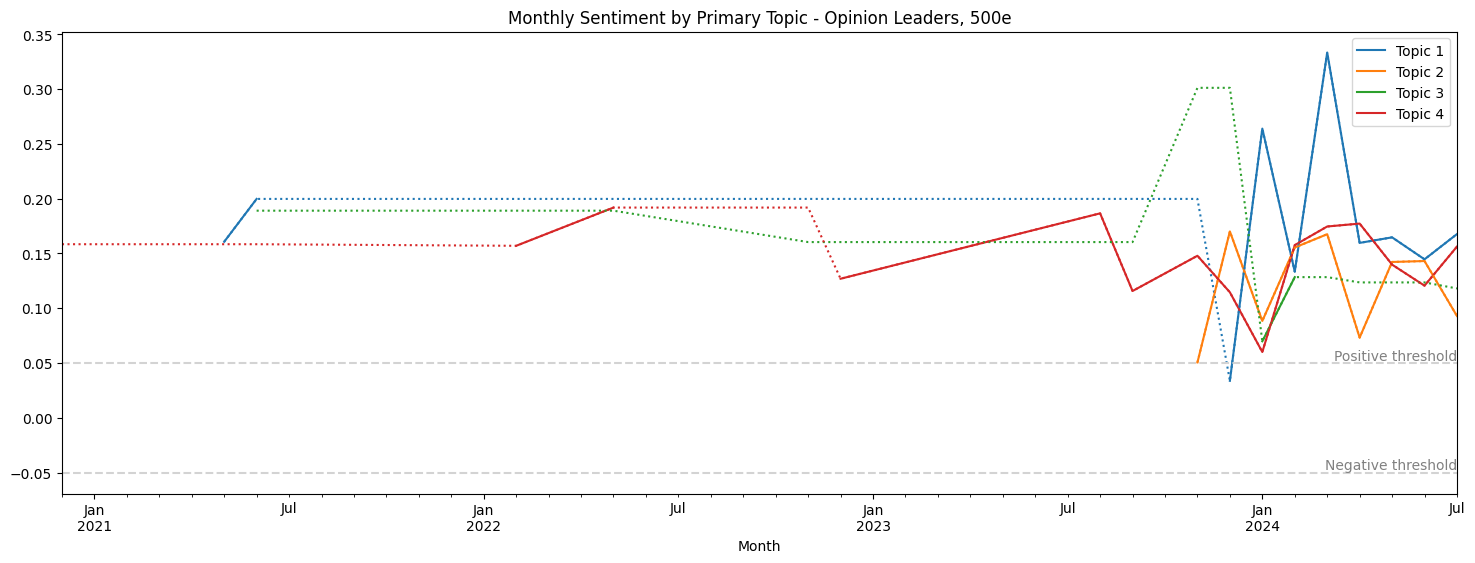

In [32]:
# Fill NaNs with last available value
filled_data = monthly_topic_sentiment_OL500.fillna(method='ffill')

# Plot the original data without markers
ax = monthly_topic_sentiment_OL500.plot(figsize=(18, 6), title='Monthly Sentiment by Primary Topic - Opinion Leaders, 500e')

# Plot filled data with the same colors but dotted lines
for column in filled_data.columns:
    filled_data[column].plot(ax=ax, linestyle=':', color=ax.get_lines()[filled_data.columns.get_loc(column)].get_color(), legend=False)

# Add threshold lines
plt.axhline(y=-0.05, color='lightgray', linestyle='--')
plt.axhline(y=0.05, color='lightgray', linestyle='--')
plt.text(monthly_topic_sentiment_OL500.index[-1], -0.05, 'Negative threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')
plt.text(monthly_topic_sentiment_OL500.index[-1], 0.05, 'Positive threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
# Only keep solid line handles in the legend
solid_line_handles = [handle for handle in handles if isinstance(handle, plt.Line2D) and handle.get_linestyle() == '-']
solid_line_labels = [labels[handles.index(handle)] for handle in solid_line_handles]
ax.legend(solid_line_handles, solid_line_labels)

# Show plot
plt.show()

# Opinion Leaders 600e: Articles & Youtube Video Transcripts

In [41]:
opinionLeaders600_original = pd.read_csv('/Users/medinazelimger/Downloads/ARP/Web-Scraping Data and adjusting codes/Opinion Leaders/600e - Opinion Leaders.csv')
opinionLeaders600 = opinionLeaders600_original.copy()

Optimal settings: 4 topics, Alpha: 0.1, Passes: 20, Coherence Score: 0.34076822691796127


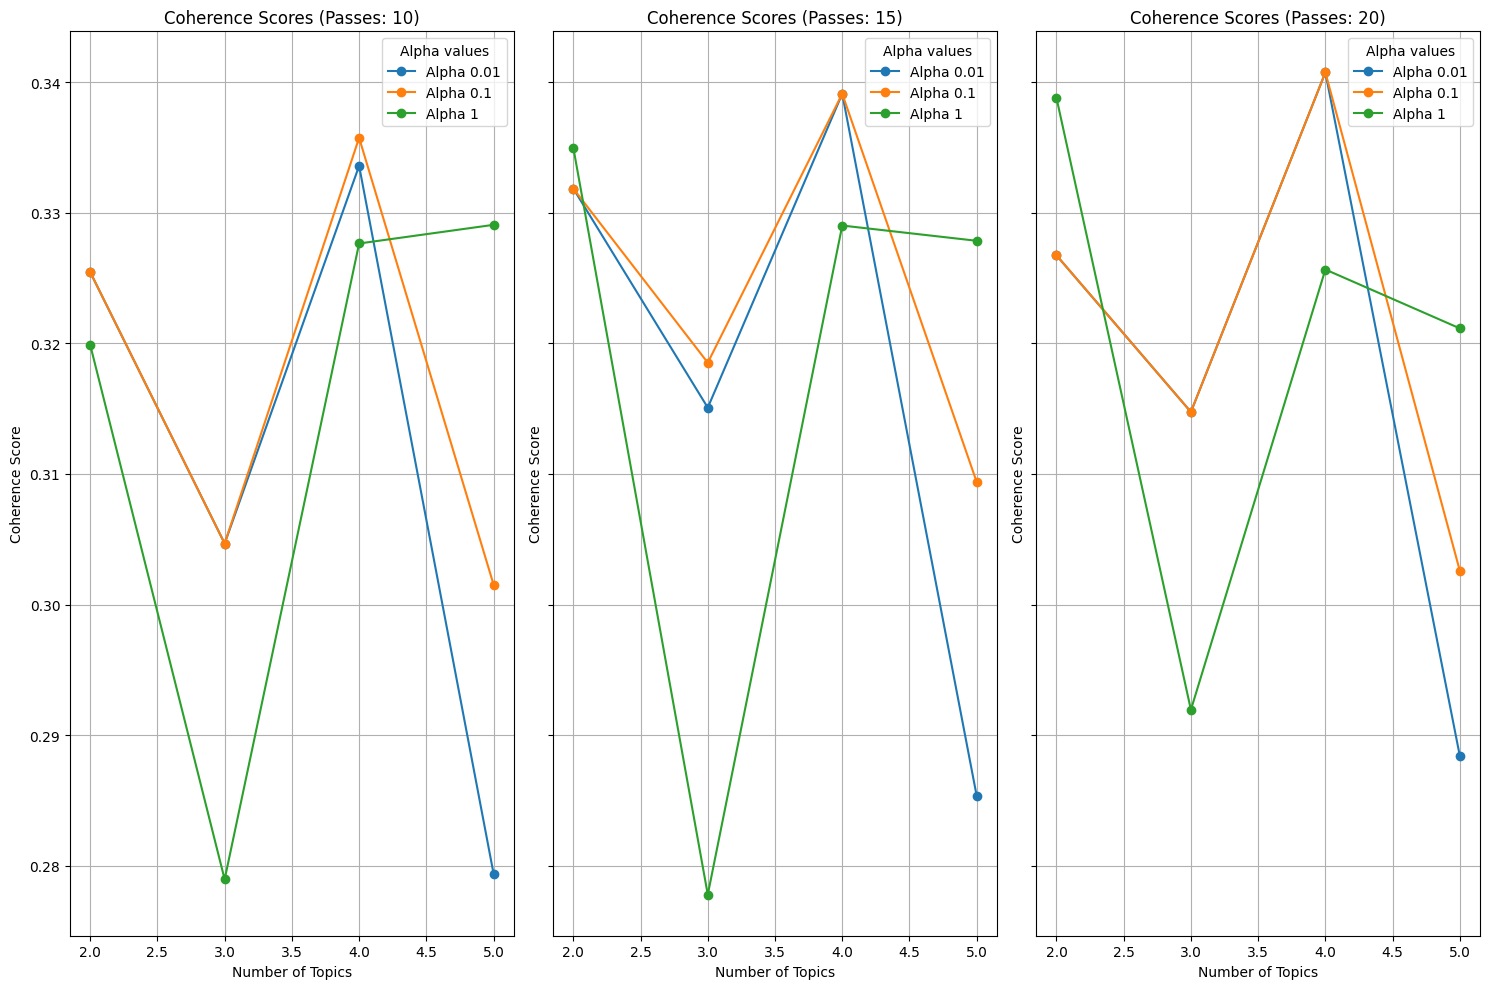

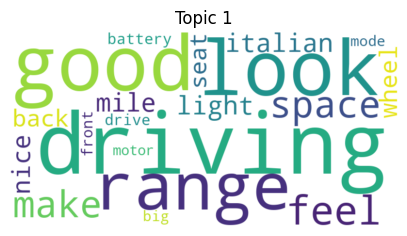

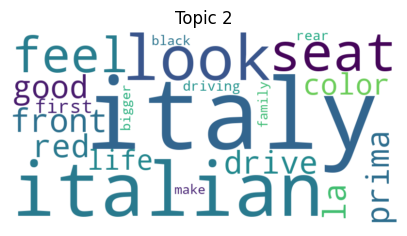

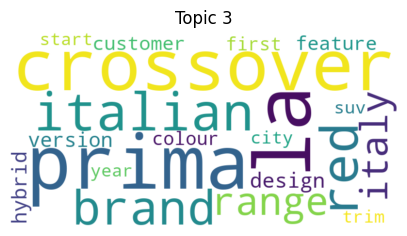

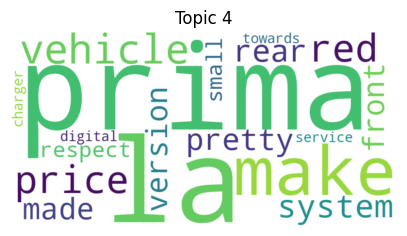

In [42]:
# drop published title and channel name
opinionLeaders600 = opinionLeaders600.drop(columns=['Date', 'Title', 'Channel Name'])

# Processing the documents
processed_docs = [preprocess(doc) for doc in opinionLeaders600['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Compute models and coherence
num_topics_range = range(2, 6)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_OL600 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_OL600['num_topics']} topics, Alpha: {optimal_result_OL600['alpha']}, Passes: {optimal_result_OL600['passes']}, Coherence Score: {optimal_result_OL600['coherence']}")

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_OL600 = optimal_result_OL600['model']
optimal_num_topics_OL600 = optimal_result_OL600['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=610)
for i in range(optimal_num_topics_OL600):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_OL600.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [43]:
lda_OL600 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_OL600, alpha=optimal_result_OL600['alpha'], passes=optimal_result_OL600['passes'], random_state=610)

In [44]:
for idx, topic in lda_OL600.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.006*"driving" + 0.006*"good" + 0.006*"look" + 0.006*"range" + 0.006*"feel" + 0.005*"space" + 0.005*"make" + 0.005*"italian" + 0.005*"light" + 0.004*"mile"
Topic: 1 
Words: 0.006*"italy" + 0.005*"italian" + 0.005*"look" + 0.005*"seat" + 0.004*"feel" + 0.004*"front" + 0.004*"prima" + 0.004*"red" + 0.004*"good" + 0.004*"drive"
Topic: 2 
Words: 0.009*"la" + 0.008*"prima" + 0.008*"crossover" + 0.007*"italian" + 0.007*"red" + 0.006*"brand" + 0.005*"range" + 0.005*"italy" + 0.005*"design" + 0.005*"version"
Topic: 3 
Words: 0.009*"entity" + 0.007*"choice" + 0.006*"prima" + 0.006*"la" + 0.006*"make" + 0.006*"vehicle" + 0.005*"price" + 0.005*"red" + 0.004*"system" + 0.004*"rear"


In [45]:
# Visualise topics using pyLDAvis
OL600_vis = gensimvis.prepare(lda_OL600, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(OL600_vis)

In [46]:
# Get the topic distribution for each document
OL600_topic_matrix = [lda_OL600[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
opinionLeaders600['Topic 1'] = [dict(doc).get(0, 0) for doc in OL600_topic_matrix]
opinionLeaders600['Topic 2'] = [dict(doc).get(1, 0) for doc in OL600_topic_matrix]
opinionLeaders600['Topic 3'] = [dict(doc).get(2, 0) for doc in OL600_topic_matrix]
opinionLeaders600['Topic 4'] = [dict(doc).get(3, 0) for doc in OL600_topic_matrix]

# Add 'Date' columns from the original table
date_map = dict(zip(opinionLeaders600_original['ID'], opinionLeaders600_original['Date']))
opinionLeaders600['Date'] = opinionLeaders600['ID'].map(date_map)

# Display the table with the new topic columns
opinionLeaders600.head()

,ID,Text,Topic 1,Topic 2,Topic 3,Topic 4,Date
0,https://news.google.com/articles/CBMiHmh0dHBzO...,JAKARTA - Fiat recently revealed their latest ...,0.000000,0.0,0.0,0.994947,2023-12-29
1,https://news.google.com/articles/CBMiJ2h0dHBzO...,"Customers asked for more crossovers, and Fiat ...",0.999083,0.0,0.0,0.000000,2023-08-21
2,https://news.google.com/articles/CBMiJ2h0dHBzO...,\nRelatively affordable to buy. Very useable 2...,0.999643,0.0,0.0,0.000000,2023-09-27
3,https://news.google.com/articles/CBMiKWh0dHBzO...,4.0 out of 5 The ‘Frappuccino' of the small el...,0.143957,0.0,0.0,0.855425,2023-09-22
4,https://news.google.com/articles/CBMiNGh0dHBzO...,There are two specifications available on the ...,0.000000,0.0,0.0,0.994272,2024-03-05


In [47]:
# Apply sentiment analysis to each document
opinionLeaders600['Sentiment'] = opinionLeaders600['Text'].apply(get_sentiment)

# Determine the primary topic for each document
opinionLeaders600['Primary_Topic'] = opinionLeaders600[['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment_OL600 = opinionLeaders600.groupby('Primary_Topic')['Sentiment'].mean()
print(topic_sentiment_OL600)

# Calculate mean sentiment for each topic monthly
opinionLeaders600['Month'] = pd.to_datetime(opinionLeaders600['Date']).dt.to_period('M')
monthly_topic_sentiment_OL600 = opinionLeaders600.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment_OL600 = opinionLeaders600.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment_OL600)

Primary_Topic
Topic 1    0.121163
Topic 2    0.040507
Topic 3    0.119715
Topic 4    0.125016
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2   Topic 3   Topic 4
Month                                                
2023-06        0.111777 -0.125000  0.141684  0.116425
2023-07        0.071804  0.139228  0.115193  0.136510
2023-08        0.112353       NaN       NaN       NaN
2023-09        0.164143 -0.040197  0.028412  0.121922
2023-10        0.148043       NaN       NaN       NaN
2023-11        0.182409       NaN       NaN  0.162251
2023-12        0.098052       NaN  0.267273  0.080063
2024-01        0.199762       NaN       NaN       NaN
2024-03        0.134863  0.169980  0.155078  0.198173
2024-04        0.244056       NaN       NaN       NaN
2024-06       -0.023611       NaN  0.207297       NaN
2024-07             NaN       NaN  0.128918  0.032060


/var/folders/jc/jzhhjb8d3299gvfnh3tpk6t80000gn/T/ipykernel_48232/1541865323.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data = monthly_topic_sentiment_OL600.fillna(method='ffill')


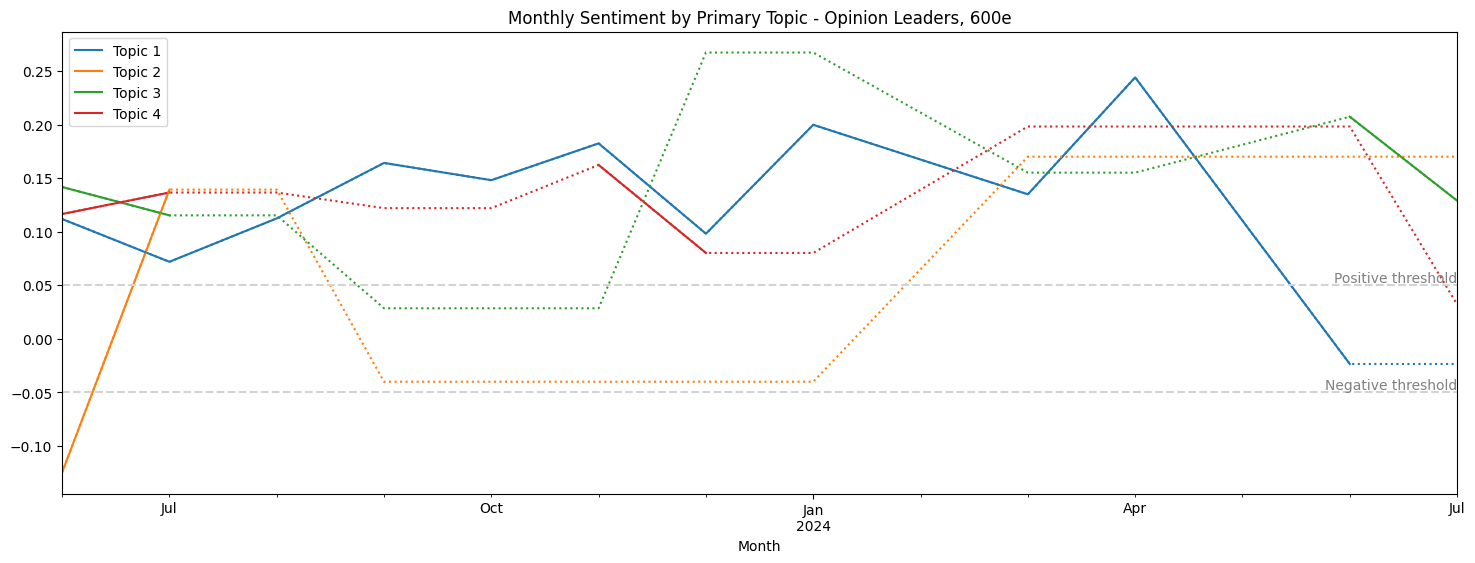

In [48]:
# Fill NaNs with last available value
filled_data = monthly_topic_sentiment_OL600.fillna(method='ffill')

# Plot the original data without markers
ax = monthly_topic_sentiment_OL600.plot(figsize=(18, 6), title='Monthly Sentiment by Primary Topic - Opinion Leaders, 600e')

# Plot filled data with the same colors but dotted lines
for column in filled_data.columns:
    filled_data[column].plot(ax=ax, linestyle=':', color=ax.get_lines()[filled_data.columns.get_loc(column)].get_color(), legend=False)

# Add threshold lines
plt.axhline(y=-0.05, color='lightgray', linestyle='--')
plt.axhline(y=0.05, color='lightgray', linestyle='--')
plt.text(monthly_topic_sentiment_OL600.index[-1], -0.05, 'Negative threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')
plt.text(monthly_topic_sentiment_OL600.index[-1], 0.05, 'Positive threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
# Only keep solid line handles in the legend
solid_line_handles = [handle for handle in handles if isinstance(handle, plt.Line2D) and handle.get_linestyle() == '-']
solid_line_labels = [labels[handles.index(handle)] for handle in solid_line_handles]
ax.legend(solid_line_handles, solid_line_labels)

# Show plot
plt.show()

# Potential Customers 600e: Comments 600e

In [66]:
comments_600e_original = pd.read_csv('/Users/medinazelimger/Downloads/600e - Potential Customers_20240802.csv')
comments_600e = comments_600e_original.copy()
comments_600e.head()

,Date,ID,Text
0,2024-03-08,AXGNb76QgH0,25000 is a fair price
1,2024-03-04,AXGNb76QgH0,it looks solid and i know its a great driving ...
2,2024-02-24,AXGNb76QgH0,really love the video and review of new fiat 6...
3,2024-02-16,AXGNb76QgH0,imagine if fiat invested in perfecting the 500...
4,2024-02-13,AXGNb76QgH0,my wife has a 500 c and all we love it nobody ...


Optimal settings: 2 topics, Alpha: 0.01, Passes: 15, Coherence Score: 0.45087986110211276


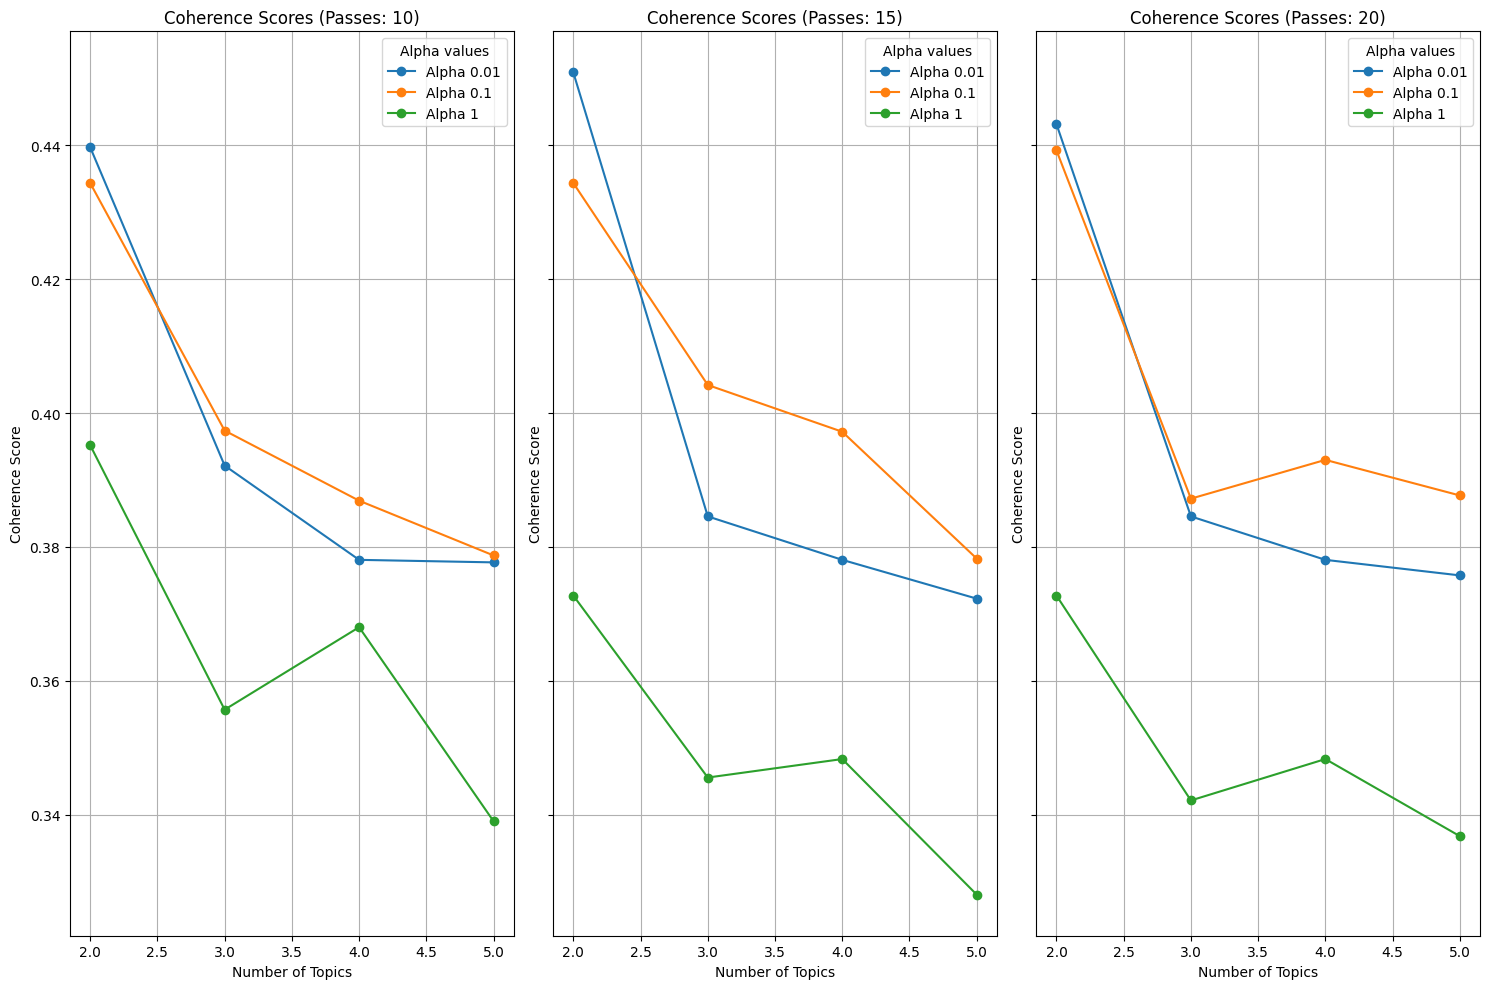

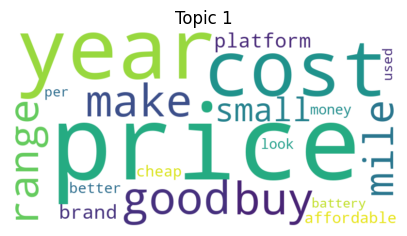

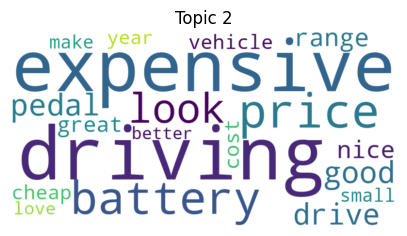

In [67]:
# Processing the documents
processed_docs = [preprocess(doc) for doc in comments_600e['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Compute models and coherence
num_topics_range = range(2, 6)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_pc600 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_pc600['num_topics']} topics, Alpha: {optimal_result_pc600['alpha']}, Passes: {optimal_result_pc600['passes']}, Coherence Score: {optimal_result_pc600['coherence']}")

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_pc600 = optimal_result_pc600['model']
optimal_num_topics_pc600 = optimal_result_pc600['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=610)
for i in range(optimal_num_topics_pc600):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_pc600.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [68]:
lda_pc600 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_pc600, alpha=optimal_result_pc600['alpha'], passes=optimal_result_pc600['passes'], random_state=610)

In [69]:
for idx, topic in lda_pc600.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"price" + 0.008*"year" + 0.008*"ev" + 0.007*"cost" + 0.006*"good" + 0.006*"buy" + 0.006*"make" + 0.005*"range" + 0.005*"mile" + 0.005*"small"
Topic: 1 
Words: 0.008*"driving" + 0.008*"expensive" + 0.008*"price" + 0.007*"battery" + 0.006*"look" + 0.006*"pedal" + 0.006*"good" + 0.005*"drive" + 0.005*"range" + 0.005*"nice"


In [70]:
# Visualise topics using pyLDAvis
pc600_vis = gensimvis.prepare(lda_pc600, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(pc600_vis)

In [71]:
# Get the topic distribution for each document
pc600_topic_matrix = [lda_pc600[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
comments_600e['Topic 1'] = [dict(doc).get(0, 0) for doc in pc600_topic_matrix]
comments_600e['Topic 2'] = [dict(doc).get(1, 0) for doc in pc600_topic_matrix]

# Display the table with the new topic columns
comments_600e.head()

,Date,ID,Text,Topic 1,Topic 2
0,2024-03-08,AXGNb76QgH0,25000 is a fair price,0.995049,0.000000
1,2024-03-04,AXGNb76QgH0,it looks solid and i know its a great driving ...,0.000000,0.998007
2,2024-02-24,AXGNb76QgH0,really love the video and review of new fiat 6...,0.000000,0.998753
3,2024-02-16,AXGNb76QgH0,imagine if fiat invested in perfecting the 500...,0.999630,0.000000
4,2024-02-13,AXGNb76QgH0,my wife has a 500 c and all we love it nobody ...,0.999334,0.000000


In [72]:
# Apply sentiment analysis to each document
comments_600e['Sentiment'] = comments_600e['Text'].apply(get_sentiment)

# Determine the primary topic for each document
comments_600e['Primary_Topic'] = comments_600e[['Topic 1', 'Topic 2']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment = comments_600e.groupby('Primary_Topic')['Sentiment'].mean()

print(topic_sentiment)


# Calculate mean sentiment for each topic monthly
comments_600e['Date'] = pd.to_datetime(comments_600e['Date'])
comments_600e['Month'] = comments_600e['Date'].dt.to_period('M')
monthly_topic_sentiment_PC600 = comments_600e.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment_PC600 = comments_600e.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment_PC600)

Primary_Topic
Topic 1    0.122784
Topic 2    0.102491
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2
Month                            
2023-06       -0.079167  0.147143
2023-07        0.397619  0.187500
2023-09        0.124659  0.073279
2023-10        0.086488  0.123680
2023-11        0.100412  0.171072
2023-12       -0.045455 -0.058667
2024-01        0.232382 -0.250000
2024-02        0.248999  0.242082
2024-03        0.192197  0.131442
2024-04        0.153507  0.275478
2024-05       -0.800000 -0.079302


/var/folders/jc/jzhhjb8d3299gvfnh3tpk6t80000gn/T/ipykernel_48232/3166383329.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_topic_sentiment_PC600 = monthly_topic_sentiment_PC600.fillna(method='ffill')


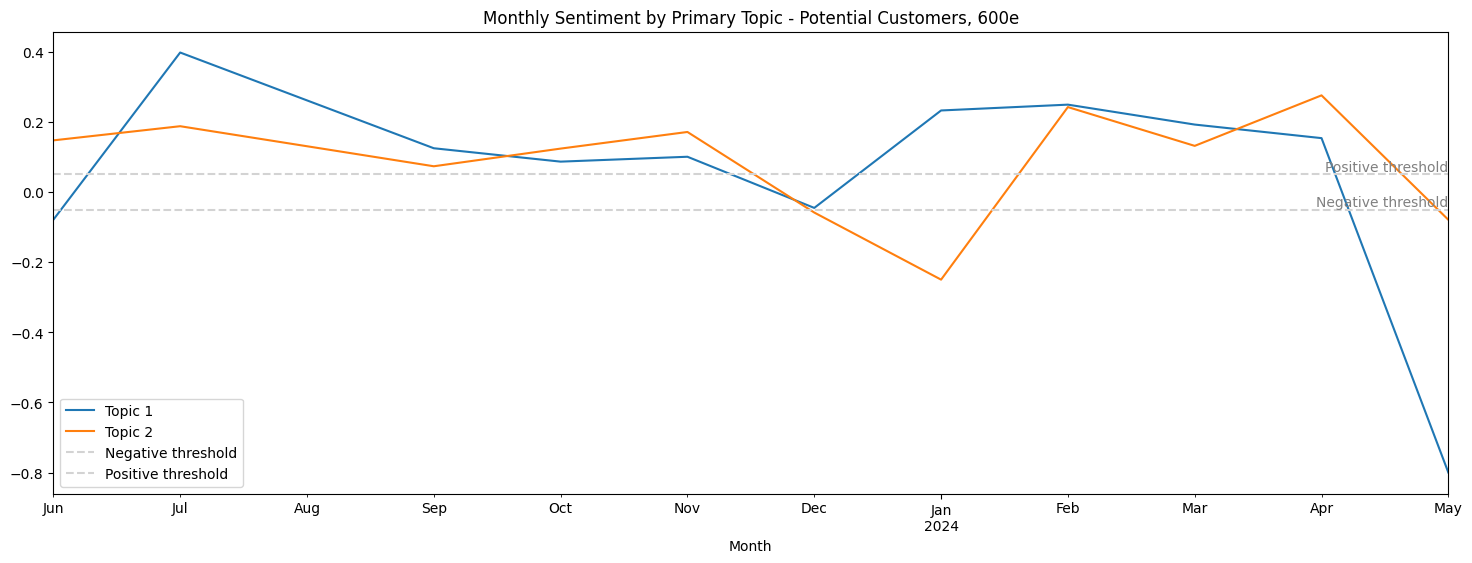

In [73]:
# Plot monthly_topic_sentiment and add lines y=-0.05 and y=0.05 for negative and positive threshold
# fill nan with last value
monthly_topic_sentiment_PC600 = monthly_topic_sentiment_PC600.fillna(method='ffill')
monthly_topic_sentiment_PC600.plot(figsize=(18, 6), title='Monthly Sentiment by Primary Topic - Potential Customers, 600e')
plt.axhline(y=-0.05, color='lightgray', linestyle='--', label='Negative threshold')
plt.axhline(y=0.05, color='lightgray', linestyle='--', label='Positive threshold')
plt.text(monthly_topic_sentiment_PC600.index[-1], -0.05, 'Negative threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')
plt.text(monthly_topic_sentiment_PC600.index[-1], 0.05, 'Positive threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')
plt.legend()
plt.show()

# Potential Customers 500e: Comments 500e

In [76]:
comments_500e_original = pd.read_csv('/Users/medinazelimger/Downloads/500e - Potential Customers_20240730.csv')
comments_500e = comments_500e_original.copy()
comments_500e.head()

,Date,Source,Text
0,2023-07-21,SpeakEV,hi there we will receive our new fiat 500e ico...
1,2023-08-17,SpeakEV,hi there i have ordered a fiat 500e icon on le...
2,2022-10-22,SpeakEV,i had my 2015 fiat 500e shipped from ca a few ...
3,2023-09-12,SpeakEV,the latest fiat 500e la prima designio by kahn...
4,2023-09-26,SpeakEV,is there a way to delete not just unselect a c...


Optimal settings: 2 topics, Alpha: 0.01, Passes: 20, Coherence Score: 0.453292426303098


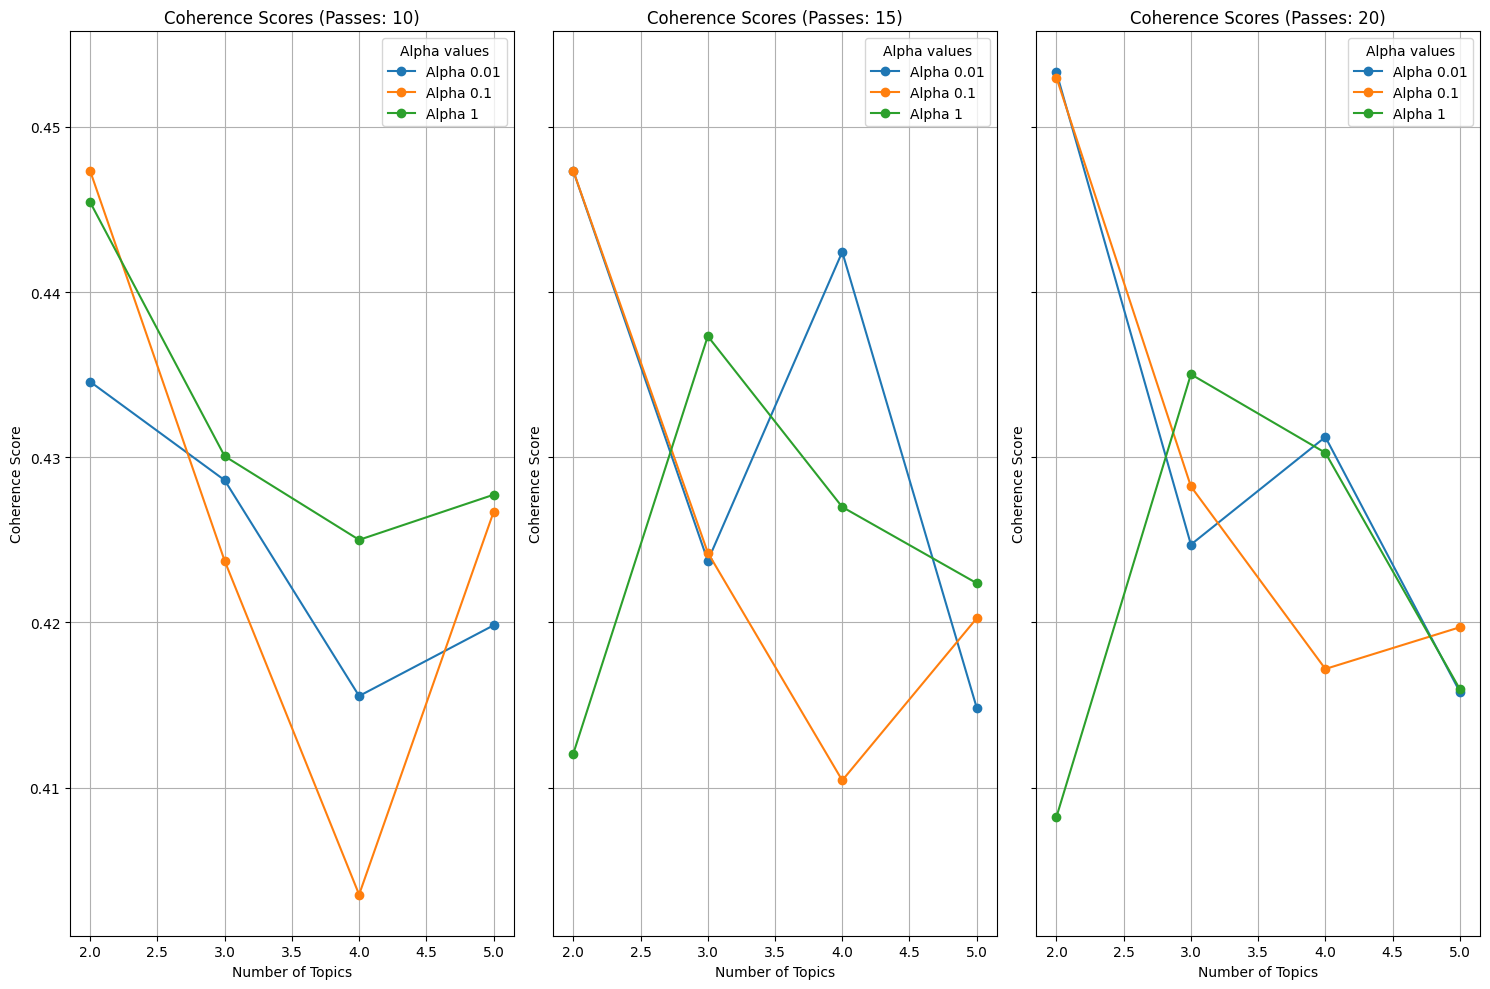

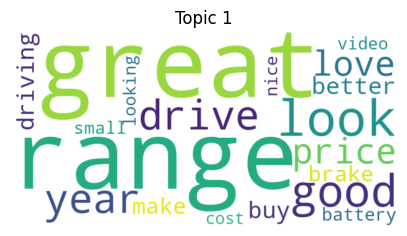

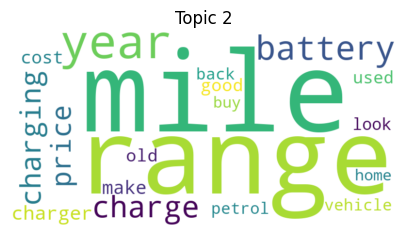

In [77]:
# Processing the documents
processed_docs = [preprocess(doc) for doc in comments_500e['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Compute models and coherence
num_topics_range = range(2, 6)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_pc500 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_pc500['num_topics']} topics, Alpha: {optimal_result_pc500['alpha']}, Passes: {optimal_result_pc500['passes']}, Coherence Score: {optimal_result_pc500['coherence']}")

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_pc500 = optimal_result_pc500['model']
optimal_num_topics_pc500 = optimal_result_pc500['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=610)
for i in range(optimal_num_topics_pc500):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_pc500.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [78]:
lda_pc500 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_pc500, alpha=optimal_result_pc500['alpha'], passes=optimal_result_pc500['passes'], random_state=610)

In [79]:
for idx, topic in lda_pc500.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.007*"range" + 0.007*"great" + 0.006*"look" + 0.006*"good" + 0.005*"drive" + 0.005*"year" + 0.005*"price" + 0.005*"love" + 0.004*"better" + 0.004*"driving"
Topic: 1 
Words: 0.010*"mile" + 0.008*"range" + 0.008*"year" + 0.007*"battery" + 0.006*"charge" + 0.005*"charging" + 0.005*"price" + 0.005*"ev" + 0.005*"charger" + 0.004*"make"


In [80]:
# Visualise topics using pyLDAvis
pc500_vis = gensimvis.prepare(lda_pc500, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(pc500_vis)

In [81]:
# Get the topic distribution for each document
pc500_topic_matrix = [lda_pc500[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
comments_500e['Topic 1'] = [dict(doc).get(0, 0) for doc in pc500_topic_matrix]
comments_500e['Topic 2'] = [dict(doc).get(1, 0) for doc in pc500_topic_matrix]

# Display the table with the new topic columns
comments_500e.head()

,Date,Source,Text,Topic 1,Topic 2
0,2023-07-21,SpeakEV,hi there we will receive our new fiat 500e ico...,0.0,0.999444
1,2023-08-17,SpeakEV,hi there i have ordered a fiat 500e icon on le...,0.0,0.999919
2,2022-10-22,SpeakEV,i had my 2015 fiat 500e shipped from ca a few ...,0.0,0.999092
3,2023-09-12,SpeakEV,the latest fiat 500e la prima designio by kahn...,0.0,0.999777
4,2023-09-26,SpeakEV,is there a way to delete not just unselect a c...,0.0,0.999750


In [83]:
# Apply sentiment analysis to each document
comments_500e['Sentiment'] = comments_500e['Text'].apply(get_sentiment)

# Determine the primary topic for each document
comments_500e['Primary_Topic'] = comments_500e[['Topic 1', 'Topic 2']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment = comments_500e.groupby('Primary_Topic')['Sentiment'].mean()

print(topic_sentiment)


# Calculate mean sentiment for each topic monthly
comments_500e['Date'] = pd.to_datetime(comments_500e['Date'])
comments_500e['Month'] = comments_500e['Date'].dt.to_period('M')
monthly_topic_sentiment_PC500 = comments_500e.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment_PC500 = comments_500e.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment_PC500)

Primary_Topic
Topic 1    0.168687
Topic 2    0.123099
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2
Month                            
2011-12             NaN  0.137403
2012-02             NaN  0.125926
2013-11             NaN  0.308571
2014-02        0.143750       NaN
2014-04             NaN  0.222803
...                 ...       ...
2024-03        0.075215  0.174220
2024-04        0.109248  0.197500
2024-05        0.159665  0.119004
2024-06        0.063652  0.038408
2024-07        0.231667  0.409091

[95 rows x 2 columns]


/var/folders/jc/jzhhjb8d3299gvfnh3tpk6t80000gn/T/ipykernel_48232/1454055936.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data = monthly_topic_sentiment_PC500.fillna(method='ffill')


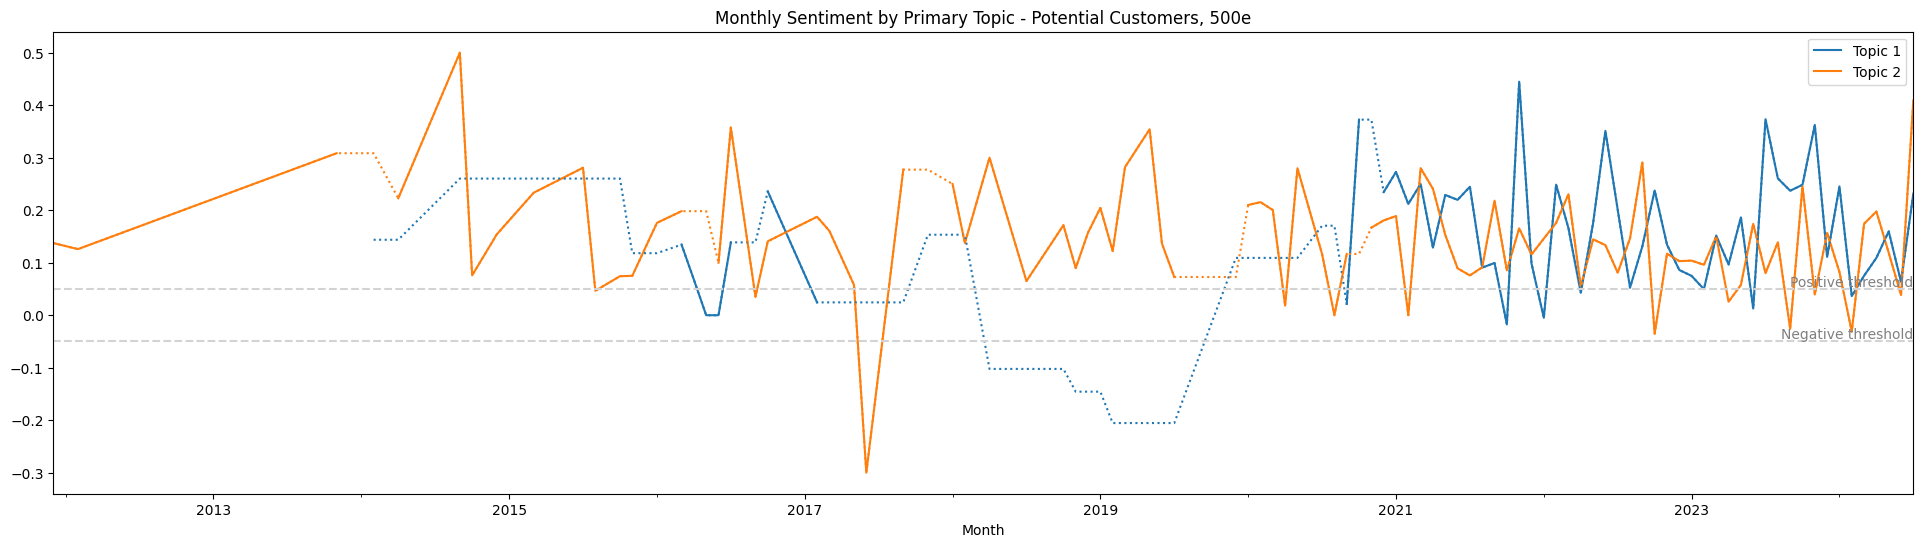

In [84]:
# Fill NaNs with last available value
filled_data = monthly_topic_sentiment_PC500.fillna(method='ffill')

# Plot the original data without markers
ax = monthly_topic_sentiment_PC500.plot(figsize=(24, 6), title='Monthly Sentiment by Primary Topic - Potential Customers, 500e')

# Plot filled data with the same colors but dotted lines
for column in filled_data.columns:
    filled_data[column].plot(ax=ax, linestyle=':', color=ax.get_lines()[filled_data.columns.get_loc(column)].get_color(), legend=False)

# Add threshold lines
plt.axhline(y=-0.05, color='lightgray', linestyle='--')
plt.axhline(y=0.05, color='lightgray', linestyle='--')
plt.text(monthly_topic_sentiment_PC500.index[-1], -0.05, 'Negative threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')
plt.text(monthly_topic_sentiment_PC500.index[-1], 0.05, 'Positive threshold', verticalalignment='bottom', horizontalalignment='right', color='gray')

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
# Only keep solid line handles in the legend
solid_line_handles = [handle for handle in handles if isinstance(handle, plt.Line2D) and handle.get_linestyle() == '-']
solid_line_labels = [labels[handles.index(handle)] for handle in solid_line_handles]
ax.legend(solid_line_handles, solid_line_labels)

# Show plot
plt.show()